# Code for Identifying Breakpoints

This notebook contains the analysis which corresponds to the figures in the chapter related to breakpoint analysis.

In [1]:
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json
import torch, tqdm, pickle
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json
import tqdm

In [2]:
with open('../data/split_keys.json') as fp:
    json_object = json.load(fp)

validation_tasks = json_object['val']

## Code for Generating Sequence Level Probabilities

=== Task aabf363d Program ===
x1 = leastcolor(I)
x2 = replace(I, x1, ZERO)
x3 = leastcolor(x2)
O = replace(x2, x3, x1)


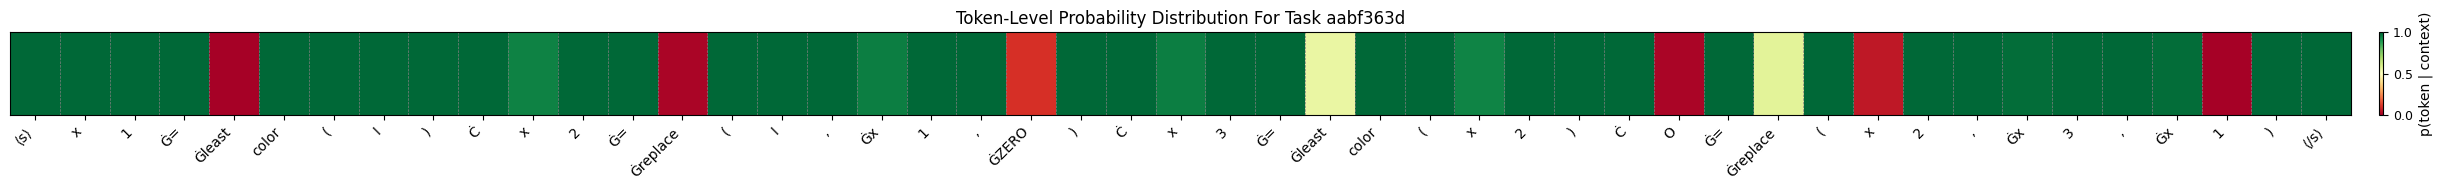

In [5]:
from alphaarc.policy.tokenize import tokenize_task

def encode_task(task, tokenizer, model, input_state_max=256, n_examples=10, max_length=256): 
    tokenized_task = np.array(tokenize_task(task, tokenizer, n_examples, input_state_max, max_length)['input_ids'])
    return tokenized_task


def output_program_lines(task):
    print(f"=== Task {task.task_key} Program ===")

    print(task.program_lines)


def compute_logits(task, model, ): 
    tok      = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m')
    target_text = task.program_lines
    model.eval()

    # teacher-forcing forward pass
    input_   = torch.tensor(encode_task(task, tok, model)).unsqueeze(0)

    ids      = tok(target_text, return_tensors="pt").input_ids

    with torch.no_grad():
        logits = model(input_, labels =ids).logits        # [1, seq_len, vocab]
    
    log_p     = torch.log_softmax(logits, -1)

    token_logp = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)  
    p_token    = token_logp.exp().squeeze().tolist()            
    tokens     = tok.convert_ids_to_tokens(ids[0])

    return tokens, p_token


 
def output_correct_token_probs(task_id, tokens, p_token): 
    fig, ax = plt.subplots(figsize=(len(tokens) * 0.6, 2))
    im = ax.imshow(np.array([p_token]), aspect="auto", cmap="RdYlGn", vmin=0, vmax=1)

    display_tokens = [t.replace("<s>", "⟨s⟩").replace("</s>", "⟨/s⟩") for t in tokens]

    ax.set_yticks([])
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(display_tokens, rotation=45, ha="right", fontsize=10)
    
    ax.set_xticks(np.arange(-.5, len(tokens), 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='minor', bottom=False)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label("p(token | context)", fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    plt.title(f"Token-Level Probability Distribution For Task {task_id}")
    plt.tight_layout()
    plt.show()

def generate_task_level_analysis(task_id, model_path='../finetune/2025-05-27_17-42-37/checkpoint-1100'): 
    task = Task.from_json(f'../data/training/{task_id}.json')
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    output_program_lines(task)
    tokens, p_token = compute_logits(task, model)
    output_correct_token_probs(task.task_key, tokens, p_token)


    
# change here the task and model you wish to use.
task = validation_tasks[14 ]
generate_task_level_analysis(task, model_path='../finetune-checkpoint/dev-checkpoint')